<h2>Palantir analysis notebook</h2>

<h3>Table of contents</h3>
<br/>
<a href='#intro'>Introduction</a>
<br/>
<a href='#data'>Loading data</a>
<br/>
<a href='#pre'>Data Processing</a>
<br/>
<a href='#palantir'>Running Palantir</a>
<br/>
<a href='#palantir2'>Visualizing Palantir results</a>
<br/>
<a href='#trends'>Gene expression trends</a>
<br/>
<a href='#clustering'>Clustering of gene expression trends</a>

<a id="intro"></a><h2> Introduction </h2>

Palantir is an algorithm to align cells along differentiation trajectories. Palantir models differentiation as a stochastic process where stem cells differentiate to terminally differentiated cells by a series of steps through a low dimensional phenotypic manifold. Palantir effectively captures the continuity in cell states and the stochasticity in cell fate determination. 

See <a href="https://www.nature.com/articles/s41587-019-0068-4">our manuscript</a> for more details.

## Imports

In [1]:
import palantir
import scanpy as sc
import pandas as pd
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

# Inline plotting
%matplotlib inline

<a id="data"></a><h2> Loading data </h2>

We recommend the use of <a href="https://scanpy-tutorials.readthedocs.io/en/latest/index.html">scanpy</a> <a href="https://anndata.readthedocs.io/en/latest/">Anndata</a> objects as the preferred mode of loading and filtering data. 

A sample RNA-seq csv data is available at <a href="https://dp-lab-data-public.s3.amazonaws.com/palantir/marrow_sample_scseq_counts.h5ad">. This sample data will be used to demonstrate the utilization and capabilities of the Palantir package. This dataset contains ~4k cells and ~16k genes and is pre-filtered. Check the <a href="https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html">scanpy introductory tutorial</a> for filtering cells and genes. 



In [2]:
# Load sample data
data_dir = os.path.expanduser("./")
download_url = "https://dp-lab-data-public.s3.amazonaws.com/palantir/marrow_sample_scseq_counts.h5ad"
file_path = os.path.join(data_dir, "marrow_sample_scseq_counts.h5ad")
ad = sc.read(file_path, backup_url=download_url)
ad

AnnData object with n_obs × n_vars = 4142 × 16106

<b>NOTE</b>: Counts are assumed to the normalized. If you have already normalized the data, skip past the `Normalization` section

## Data processing

### Normalization

Normalize the data for molecule count distribution using the `scanpy` interface

In [3]:
sc.pp.normalize_per_cell(ad)

We recommend that the data be log transformed. Note that, some datasets show better signal in the linear scale while others show stronger signal in the log scale.

The function below uses a `pseudocount` of 0.1 instead of 1.

In [4]:
palantir.preprocess.log_transform(ad)

### Highly variable gene selection

Highly variable gene selection can also be performed using the `scanpy` interface

In [5]:
sc.pp.highly_variable_genes(ad, n_top_genes=1500, flavor="cell_ranger")

### PCA

PCA is the first step in data processing for Palantir. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data. 

Rather than use a fixed number of PCs, we recommend the use of components that explain 85% of the variance in the data after highly variable gene selection.

In [6]:
# Note in the manuscript, we did not use highly variable genes but scanpy by default uses only highly variable genes
sc.pp.pca(ad)

In [7]:
ad

AnnData object with n_obs × n_vars = 4142 × 16106
    obs: 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Diffusion maps

Palantir next determines the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data.

In [8]:
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(ad, n_components=5)

Determing nearest neighbor graph...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The low dimensional embeddeing of the data is estimated based on the eigen  gap using the following function

In [9]:
ms_data = palantir.utils.determine_multiscale_space(ad)

If you are specifying the number of eigen vectors manually in the above step, please ensure that the specified parameter is > 2

### Visualization

In the manuscript, we used tSNE projection using diffusion components to visualize the data. We now recommend the use of force-directed layouts for visualization of trajectories. Force-directed layouts can be computed by the same adaptive kernel used for determining diffusion maps.

`scanpy` can be used to compute force directed layouts. We recommened the use of the diffusion kernel (see below) for computing force directed layouts
`Force Atlas` package should be installed for this analysis and can be installed using `conda install -c conda-forge fa2`. Note that fa2 is not supported by python3.9

UMAPs are a good alternative to visualize trajectories in addition to force directed layouts.

In [10]:
sc.pp.neighbors(ad)
sc.tl.umap(ad)

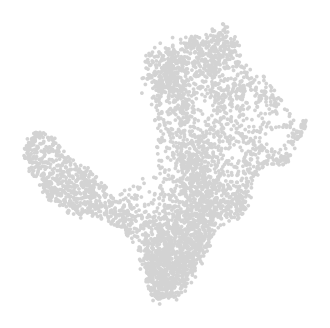

In [11]:
# Use scanpy functions to visualize umaps or FDL
sc.pl.embedding(
    ad,
    basis="umap",
    frameon=False,
)

### MAGIC imputation 

<a href="https://github.com/pkathail/magic">MAGIC</a> is an imputation technique developed in the Pe'er lab for single cell data imputation. Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.

In [12]:
imputed_X = palantir.utils.run_magic_imputation(ad)

Gene expression can be visualized on umaps using the `scanpy` functions. The `genes` parameter is an string iterable of genes, which are a subset of the expression of column names. The below function plots the expression of HSC gene `CD34`, myeloid gene `MPO` and erythroid precursor gene `GATA1` and  dendritic cell gene `IRF8`. 

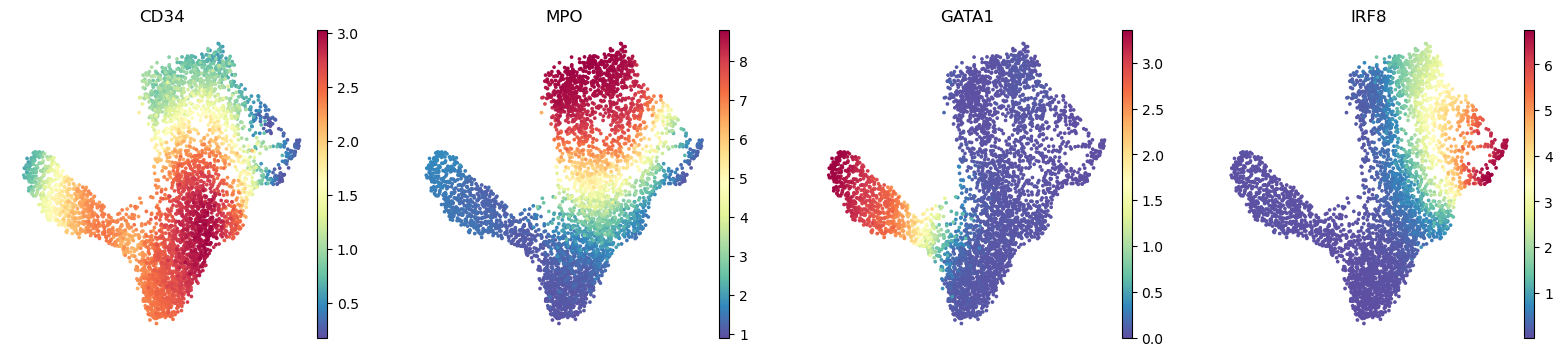

In [13]:
sc.pl.embedding(
    ad,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["CD34", "MPO", "GATA1", "IRF8"],
    frameon=False,
)
plt.show()

### Diffusion maps visualization

The computed diffusion components can be visualized with the following snippet.

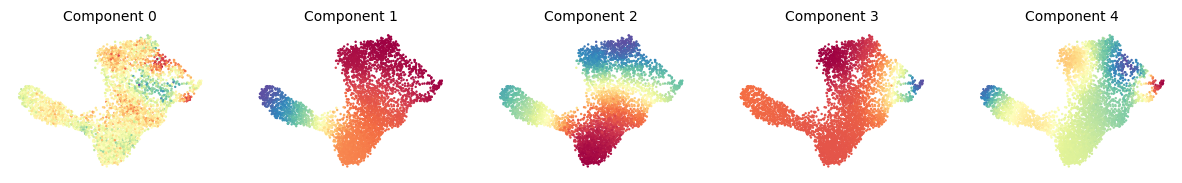

In [14]:
palantir.plot.plot_diffusion_components(ad)
plt.show()

<a id="palantir"></a><h2> Running Palantir </h2>

Palantir can be run by specifying an approxiate early cell. 

Palantir can automatically determine the terminal states as well. In this dataset, we know the terminal states and we will set them using the ```terminal_states``` parameter

The start cell for this dataset was chosen based on high expression of CD34.

In [15]:
terminal_states = pd.Series(
    ["DC", "Mono", "Ery"],
    index=["Run5_131097901611291", "Run5_134936662236454", "Run4_200562869397916"],
)

The cells can be highlighted on the UMAP map using the `highlight_cells_on_umap` function

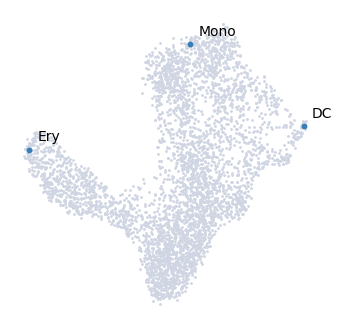

In [16]:
palantir.plot.highlight_cells_on_umap(ad, terminal_states)
plt.show()

In [17]:
start_cell = "Run5_164698952452459"
pr_res = palantir.core.run_palantir(
    ad, start_cell, num_waypoints=500, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.00488508145014445 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.18955812056859334 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Palantir generates the following results 
1. Pseudotime: Pseudo time ordering of each cell
2. Terminal state probabilities: Matrix of cells X terminal states. Each entry represents the probability of the corresponding cell reaching the respective terminal state
3. Entropy: A quantiative measure of the <i>differentiation potential</i> of each cell computed as the entropy of the multinomial terminal state probabilities

<a id="palantir2"></a><h2> Visualizing Palantir results </h2>

Palantir results can be visualized on the tSNE or UMAP using the `plot_palantir_results` function

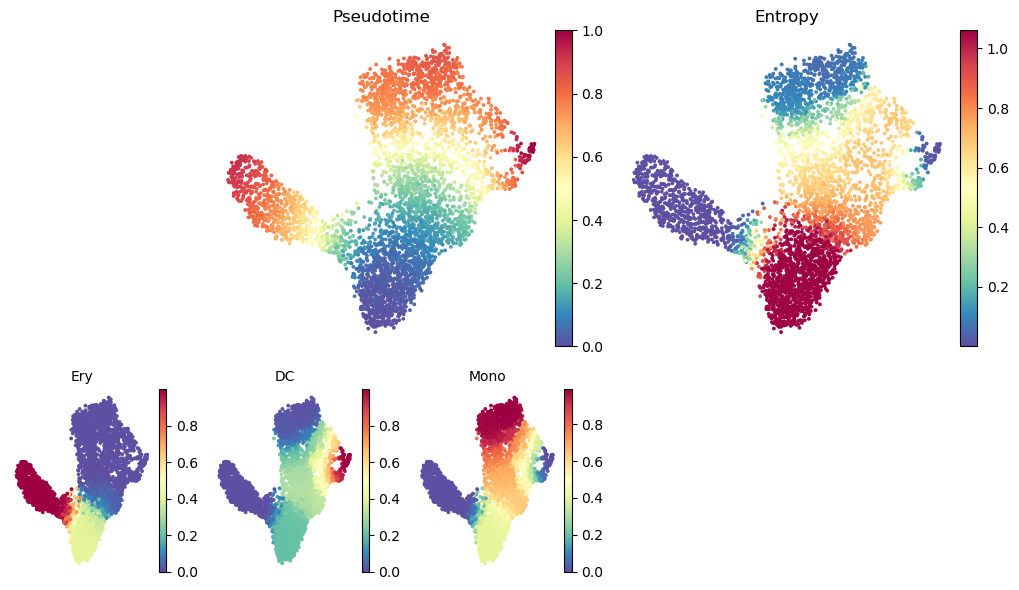

In [18]:
palantir.plot.plot_palantir_results(ad, s=3)
plt.show()

Terminal state probability distributions of individual cells can be visualized using the `plot_terminal_state_probs` function

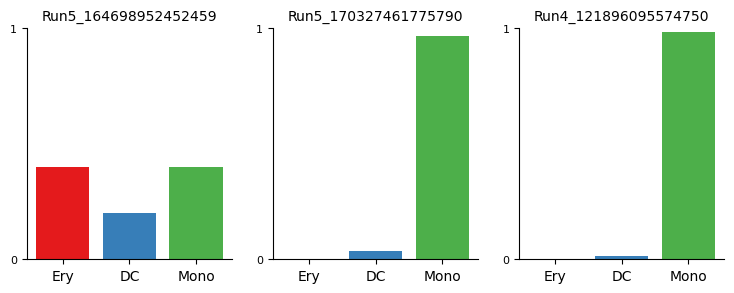

In [19]:
cells = [
    "Run5_164698952452459",
    "Run5_170327461775790",
    "Run4_121896095574750",
]
palantir.plot.plot_terminal_state_probs(ad, cells)
plt.show()

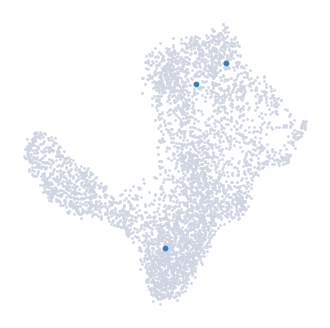

In [20]:
palantir.plot.highlight_cells_on_umap(ad, cells)
plt.show()

<a id='trends'></a><h2> Gene expression trends </h2>

Gene expression trends over pseudotime provide insights into the dynamic behavior of genes during cellular development or progression. By examining these trends, we can uncover the timing of gene expression changes and identify pivotal regulators of cellular states. Palantir provides tools for computing these gene expression trends.

Here, we'll outline the steps to compute gene trends over pseudotime using Palantir.

**Selecting cells of a specific trend**

Before computing the gene expression trends, we first need to select cells associated with a specific branch of the pseudotime trajectory. We accomplish this by using the `select_branch_cells` function. The parameter `q` is used to control the selection's stringency. 

In [21]:
masks = palantir.presults.select_branch_cells(ad, eps=0)

**Visualizing the branch selection**

Once the cells are selected, it's often helpful to visualize the selection on the pseudotime trajectory to ensure we've isolated the correct cells for our specific trend. We can do this using the `plot_branch_selection` function:

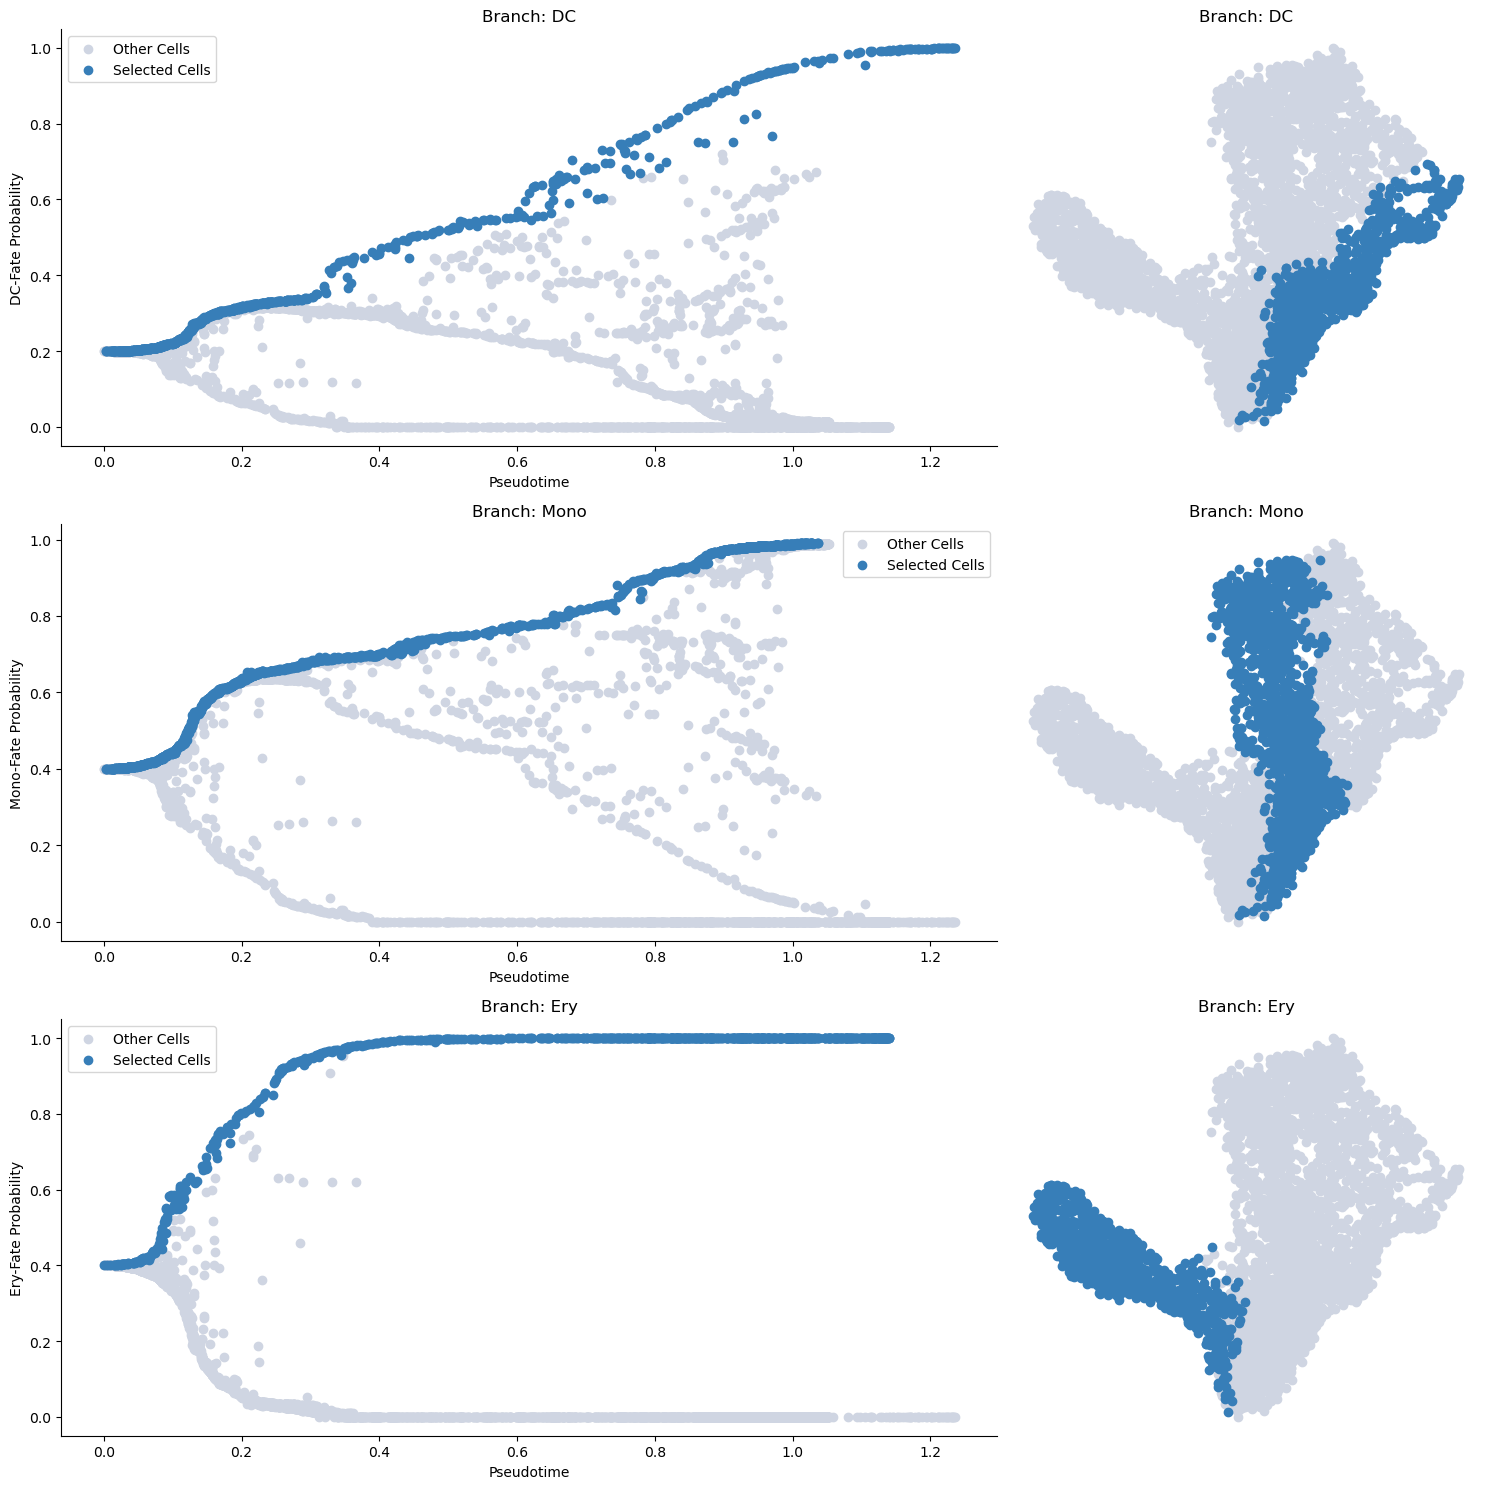

In [22]:
palantir.plot.plot_branch_selection(ad)
plt.show()

Palantir uses <a href="https://mellon.readthedocs.io/en/latest/model.html#mellon.model.FunctionEstimator">Mellon Function Estimator</a> to determine the gene expression trends along different lineages. The marker trends can be determined using the following snippet. This computes the trends for all lineages. A subset of lineages can be used using the `lineages` parameter.


In [23]:
gene_trends = palantir.presults.compute_gene_trends(
    ad,
    expression_key="MAGIC_imputed_data",
)

Ery
[2023-07-11 14:34:55,919] [INFO    ] Using covariance function Matern52(ls=10.0).
DC
[2023-07-11 14:34:58,045] [INFO    ] Using covariance function Matern52(ls=10.0).
Mono
[2023-07-11 14:35:00,218] [INFO    ] Using covariance function Matern52(ls=10.0).


The determined trends can be visualized with the `plot_gene_trends` function. A separate panel is generated  for each gene

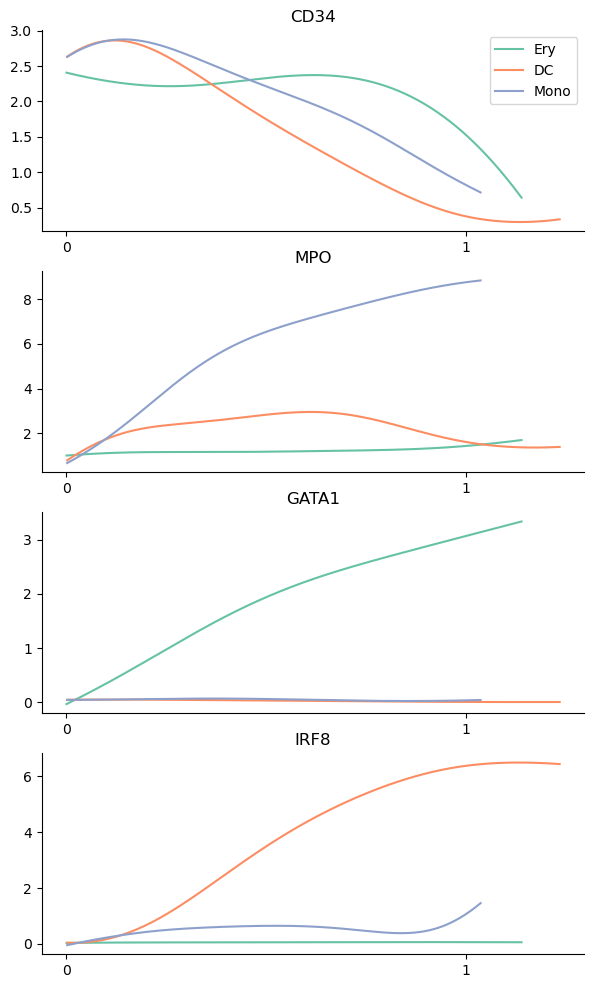

In [24]:
genes = ["CD34", "MPO", "GATA1", "IRF8"]
palantir.plot.plot_gene_trends(ad, genes)
plt.show()

Alternatively, the trends can be visualized on a heatmap using

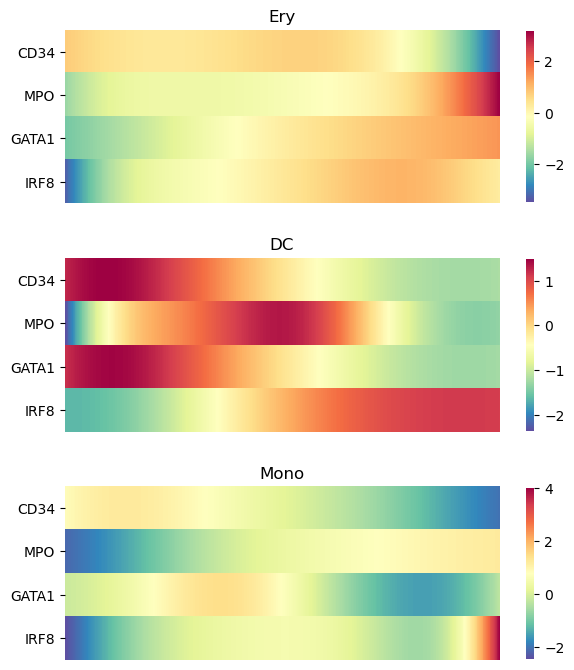

In [25]:
palantir.plot.plot_gene_trend_heatmaps(ad, genes)
plt.show()

<a id="clustering"></a><h3> Clustering </h3>

Gene expression trends can be clustered and visualized using the following snippet. As an example, the first 1000 genes along the erythroid genes are clustered

In [26]:
more_genes = ad.var_names[:1000]
communities = palantir.presults.cluster_gene_trends(ad, "Ery", more_genes)

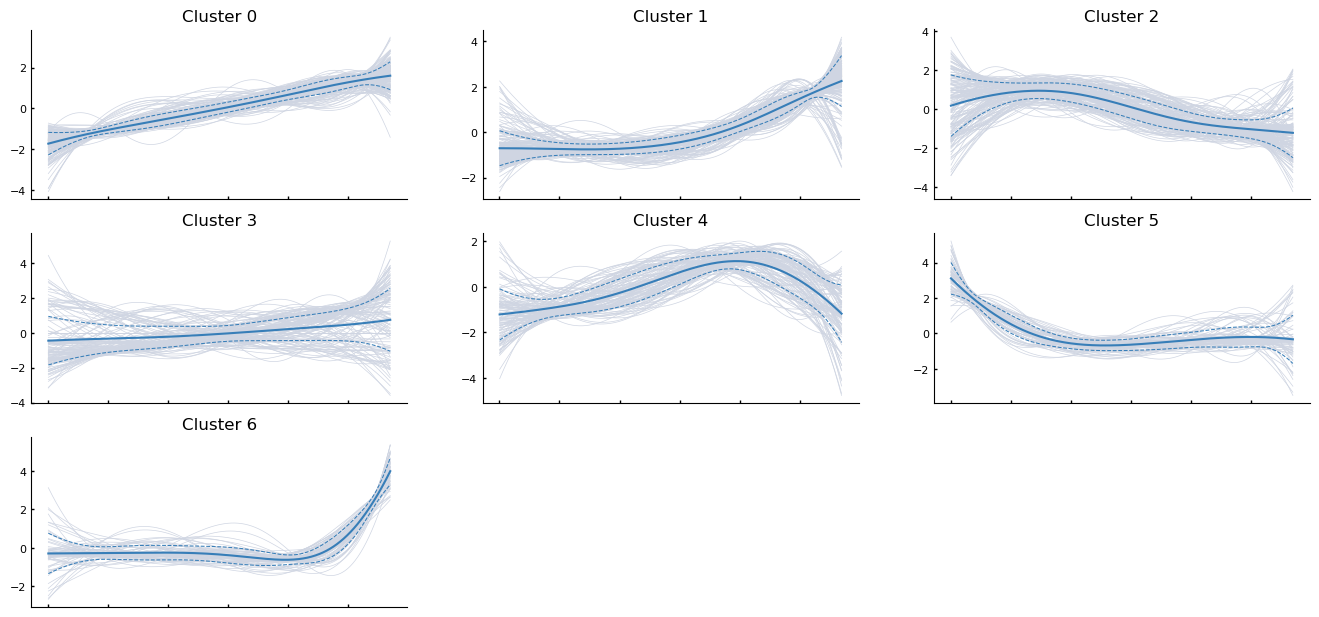

In [27]:
palantir.plot.plot_gene_trend_clusters(ad, "Ery")
plt.show()

<a id="save"></a><h3> Save results </h3>

In [28]:
file_path = os.path.join(data_dir, "marrow_sample_scseq_processed.h5ad")
ad.write(file_path)